In [1]:
from attention import AttentionLayer

In [48]:
import numpy as np  
import pandas as pd 
import re           
#from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [98]:
data=pd.read_excel("syntheses v2.xlsx")

In [99]:
#data.drop_duplicates(subset=['Text'],inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)   #dropping na

In [102]:
data['contents'][:10]

0     1.2.2019                 FR                              Journal officiel de l'Union européenne                                           C 39/1\n                                                 ...
1     15.3.2019              FR                          Journal officiel de l'Union européenne                                              L 73/93\n                                           RÈGLEMEN...
2     15.3.2019              FR                          Journal officiel de l'Union européenne                                              L 73/93\n                                           RÈGLEMEN...
3     15.3.2019              FR                          Journal officiel de l'Union européenne                                              L 73/93\n                                           RÈGLEMEN...
4     27 mars 2019                         JOURNAL OFFICIEL DE LA RÉPUBLIQUE FRANÇAISE                                                                       Texte 146 sur 168\n    

In [103]:
stop_words = set(stopwords.words('french')) 
def text_cleaner(text):
    newString = text.lower()
    #newString = BeautifulSoup(newString, features="html5lib").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    #newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['contents']:
    cleaned_text.append(text_cleaner(t))

In [54]:
data['Summary'][:10]

0                            Good Quality Dog Food
1                                Not as Advertised
2                            "Delight" says it all
3                                   Cough Medicine
4                                      Great taffy
5                                       Nice Taffy
6    Great!  Just as good as the expensive brands!
7                           Wonderful, tasty taffy
8                                       Yay Barley
9                                 Healthy Dog Food
Name: Summary, dtype: object

In [104]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    #newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in data['Text Summarization']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [105]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')

In [106]:
for i in range(5):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print("\n")

Review: journal officiel union europ enne recommandations comit europ risque syst mique recommandation comit europ risque syst mique cembre modifiant recommandation cers valuation effets transfrontaliers ciprocit volontaire mesures politique macroprudentielle conseil ral comit europ risque syst mique trait fonctionnement union europ enne glement parlement europ conseil novembre relatif surveillance macroprudentielle syst financier union europ enne instituant comit europ risque syst mique notamment article ainsi articles glement parlement europ conseil juin concernant exigences prudentielles applicables tablissements dit entreprises investissement modifiant glement notamment article paragraphe cision cers comit europ risque syst mique janvier portant adoption gle ment int rieur comit europ risque syst mique notamment articles consid rant suit afin garantir efficacit coh rence mesures nationales politique macroprudentielle convient compl ter reconnaissance obligatoire impos droit union c

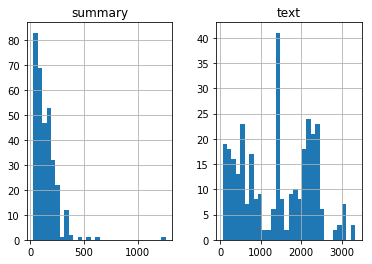

In [107]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [108]:
max_len_text=500
max_len_summary=100

In [119]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True) 

In [120]:
x_tr=x_tr[:50]
x_val=x_val[:20]
y_tr=y_tr[:50]
y_val=y_val[:20]

In [121]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [122]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [124]:
from keras import backend as K 
K.clear_session() 
latent_dim = 50

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 50)      263850      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 500, 50), (N 20200       embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [126]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [127]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [128]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=20,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Train on 50 samples, validate on 20 samples
Epoch 1/20
50/50 [==============================] - 13s 262ms/sample - loss: 7.1836 - val_loss: 7.1709
Epoch 2/20
50/50 [==============================] - 6s 114ms/sample - loss: 7.1748 - val_loss: 7.1517
Epoch 3/20
50/50 [==============================] - 9s 178ms/sample - loss: 7.1605 - val_loss: 7.0997
Epoch 4/20
50/50 [==============================] - 20s 409ms/sample - loss: 7.1205 - val_loss: 6.9190
Epoch 5/20
50/50 [==============================] - 6s 112ms/sample - loss: 6.9773 - val_loss: 6.5925
Epoch 6/20
50/50 [==============================] - 6s 121ms/sample - loss: 6.7226 - val_loss: 6.2567
Epoch 7/20
50/50 [==============================] - 5s 107ms/sample - loss: 6.4668 - val_loss: 5.9211
Epoch 8/20
50/50 [==============================] - 5s 105ms/sample - loss: 6.2041 - val_loss: 5.6875
Epoch 9/20
50/50 [==============================] - 6s 110ms/sample - loss: 6.0280 - val_loss: 5.5014
Epoch 10/20
50/50 [=================

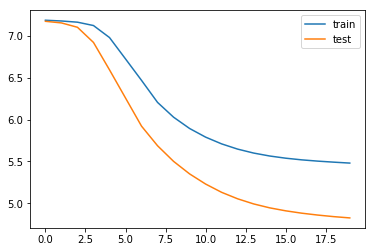

In [129]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend()
pyplot.show()

In [130]:
#to convert results to text summary
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [131]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [132]:
#inference process
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [133]:
#function to convert results to string
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [134]:
for i in range(len(x_val)):
    print("Review:",seq2text(x_val[i]))
    print("Original summary:",seq2summary(y_val[i]))
    print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
    print("\n")

Review: transparence document vrier modifi mai position recommandation amf guide documents glementaires opc doc recommandations plus lisibilit documents glementaires fonds isr devraient senter objectif gestion sentant dimension extra financi gestion types isr pratiqu ainsi ments quant thodes lection gestion pratiqu fonds communiquent objectifs mesurant impact esg devraient part veiller senter objectifs clairs cis argument valuables autre part assurer suivi objectifs temps classification opcvm classification cas ant doit tre indiqu rubrique objectifs politique investissement document information investisseur conform ment article instruction doc classification diversifi rassemble tous opcvm rel vent autre cat gorie seul cas limites exposition opcvm telles finies document information investisseur pondent aucune limite fix articles suivants instruction doc relatifs classifications celui pourra tre class diversifi jusqu cembre date apr laquelle cette classification supprim exemple opcvm aff

KeyError: 0